## Data manipulation

In [200]:
import pandas as pd

In [201]:
data = pd.read_csv(r'estat_crim_off_cat.tsv', sep='\t')

In [202]:
data = data.rename({data.columns[0]: data.columns[0].replace(r"\TIME_PERIOD", "")}, axis="columns")
split_name_columns = (data.columns[0]).split(',')
count_split_columns = len(split_name_columns)

In [203]:
data[split_name_columns] = data[data.columns[0]].str.split(',', expand=True)
data = data.drop(data.columns[0], axis="columns") #odstraneni jiz rozdeleneho sloupce

# presun rozdelenych udaju na zacatek df
reorg_columns = data.columns.tolist()
final_reorg_columns = reorg_columns[-count_split_columns:] + reorg_columns[:-count_split_columns]
data = data[final_reorg_columns]

In [204]:
data = data.replace(": ", 'NaN')

column_period = data.columns[count_split_columns:] 
data[column_period] = data[data.columns[count_split_columns:]].astype('float')

In [205]:
no_anual = data[data['freq'] != 'A'].index # podminka, ze se nejedna o rocni data
data.drop(index=no_anual, inplace=True)

no_p_hthab = data[data['unit'] != 'P_HTHAB'].index # podminka, ze se nejedna o udaj na 100tis obyvatel
data.drop(index=no_p_hthab, inplace=True)
data


,freq,iccs,unit,geo,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
41,A,ICCS0101,P_HTHAB,AL,2.78,2.57,NaN,4.38,NaN,NaN,3.38,1.86,2.46,1.81,1.78,2.03,1.83,2.16,1.50
42,A,ICCS0101,P_HTHAB,AT,0.70,0.61,0.73,0.96,1.05,0.75,0.51,0.49,0.56,0.70,0.83,0.84,0.61,0.66,0.72
43,A,ICCS0101,P_HTHAB,BA,1.72,1.74,1.40,1.27,1.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,A,ICCS0101,P_HTHAB,BE,1.91,1.76,1.74,1.95,1.86,1.83,1.88,2.06,1.55,1.74,1.68,1.28,1.30,1.33,1.54
45,A,ICCS0101,P_HTHAB,BG,2.29,2.01,1.99,1.74,1.92,1.50,1.55,1.75,1.10,1.34,1.30,1.16,0.96,1.29,1.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553,A,ICCS09051,P_HTHAB,RS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN
1554,A,ICCS09051,P_HTHAB,SI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05,0.05,0.19,0.24,0.05,0.19,0.00
1555,A,ICCS09051,P_HTHAB,SK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.11,0.11,0.17,0.11,0.18,0.26,0.15
1556,A,ICCS09051,P_HTHAB,TR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.44,NaN,NaN,NaN,NaN,NaN,NaN


In [206]:
years_list = data.columns[count_split_columns:]

In [207]:
unpivot_data = pd.melt(data, id_vars=['freq', 'iccs', 'unit', 'geo'], value_vars=years_list, var_name='year', value_name='value')
unpivot_data

,freq,iccs,unit,geo,year,value
0,A,ICCS0101,P_HTHAB,AL,2008,2.78
1,A,ICCS0101,P_HTHAB,AT,2008,0.70
2,A,ICCS0101,P_HTHAB,BA,2008,1.72
3,A,ICCS0101,P_HTHAB,BE,2008,1.91
4,A,ICCS0101,P_HTHAB,BG,2008,2.29
...,...,...,...,...,...,...
11605,A,ICCS09051,P_HTHAB,RS,2022,NaN
11606,A,ICCS09051,P_HTHAB,SI,2022,0.00
11607,A,ICCS09051,P_HTHAB,SK,2022,0.15
11608,A,ICCS09051,P_HTHAB,TR,2022,NaN


In [208]:
# unpivot_data[(unpivot_data['iccs'] == 'ICCS0101') & (unpivot_data['geo'] == 'BE')] # pro manulální kontrolu s puvodni tabulkou, zda se nam spravne pretranformovala(unpivotovala) data 

In [209]:
unpivot_data['year'] = unpivot_data['year'].astype('int')

## Data visualisation

In [210]:
import matplotlib.pyplot as plt


In [211]:
unpivot_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11610 entries, 0 to 11609
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   freq    11610 non-null  object 
 1   iccs    11610 non-null  object 
 2   unit    11610 non-null  object 
 3   geo     11610 non-null  object 
 4   year    11610 non-null  int64  
 5   value   8605 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 544.3+ KB


In [212]:
# TODO: zoptimalizovat kod a zinteraktivnit ploty
# TODO: v původním dataframu zaměnit zkratku statu za cely nazev + jak poresit zkratku tr. cinnu?

In [213]:
filtered_data = unpivot_data[(unpivot_data['geo'] == 'BE') & (unpivot_data['iccs'] == 'ICCS0101')]

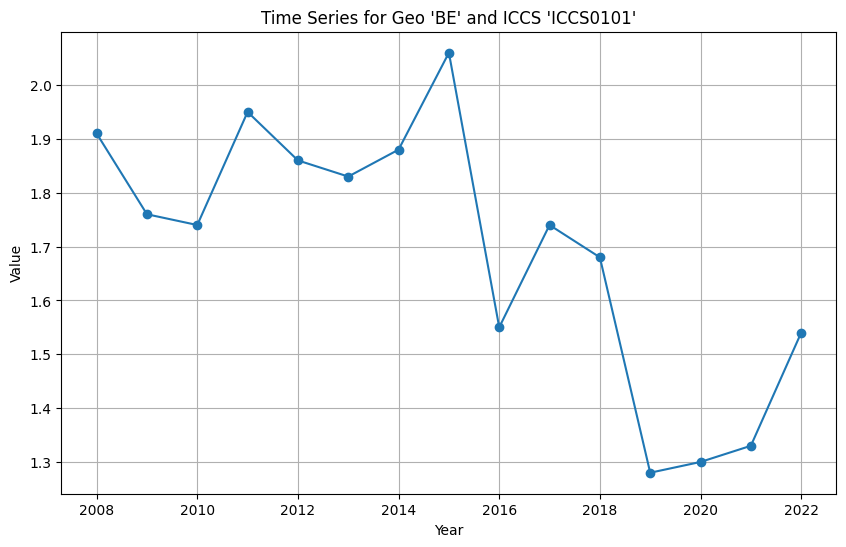

In [214]:
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['year'], filtered_data['value'], marker='o')
plt.title("Time Series for Geo 'BE' and ICCS 'ICCS0101'")
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(True)
plt.show()